In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import desc,asc,isnull,when,count,col, sum as Fsum, max as Fmax
from pyspark.sql.functions import concat, col, lit
from pyspark.sql.functions import mean
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("capstone") \
        .getOrCreate()

In [3]:
# load data
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
print("Number of rows : {}".format(df.count()))
print("Number of columns : {}".format(len(df.columns)))

Number of rows : 286500
Number of columns : 18


In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Missing Data 

In [5]:
df = df[df.userId!=""]

In [6]:
df.count()

278154

In [7]:
flag_missingSongInfo = udf(lambda x : 1 if x==None else 0, IntegerType())
df = df.withColumn("missingSongInfo",flag_missingSongInfo("artist"))

In [8]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', missingSongInfo=0)

In [9]:
df.filter(df['missingSonginfo'] == 0).count()

228108

In [10]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- missingSongInfo: integer (nullable = true)



### Categorical Variables

 - firstName, lastName, method, are userAgent probably not useful
 - gender, level should be encoded as binary
 - location needs to be further analyzed
 - artist and song need to be further analyzed and turn into numerical features
 - page needs to be converted into user behavior features

##### (1) Define churn

In [11]:
flag_cancellation = udf(lambda x : 1 if x=="Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn",flag_cancellation("page"))

In [12]:
w = Window.partitionBy('userId')

df_user = df.select('userId','churn') \
            .withColumn('churned_user',Fsum('churn').over(w)) \
            .dropDuplicates(['userId']).drop('churn')

df_user.groupby('churned_user')\
        .count().show()

+------------+-----+
|churned_user|count|
+------------+-----+
|           0|  173|
|           1|   52|
+------------+-----+



##### aggrates features 

In [13]:
df_numSessions = df.select('userId','sessionId')\
                .dropDuplicates(['sessionId','userId'])\
                .withColumn('numSessions',count(df.userId).over(w))\
                .dropDuplicates(['userId'])\
                .drop('sessionId')

In [14]:
df_numSongs = df.select('userId','song')\
                .dropDuplicates(['userId','song'])\
                .withColumn('numSongs',count(df.userId).over(w))\
                .dropDuplicates(['userId'])\
                .drop('song')

In [15]:
df_numArtists = df.select('userId','artist')\
                .dropDuplicates(['userId','artist'])\
                .withColumn('numArtists',count(df.userId).over(w))\
                .dropDuplicates(['userId'])\
                .drop('artist')

In [16]:
df_playTime = df.filter(df['page']=='NextSong')\
            .select('userId','length')\
            .withColumn('playTime',Fsum('length').over(w))\
            .dropDuplicates(['userId'])\
            .drop('song')

In [17]:
df_activeDays = df.select('userId','ts','registration')\
    .withColumn('mostRecentTs',Fmax('ts').over(w))\
    .dropDuplicates(['userId'])\
    .withColumn("activeDays",(col('ts')/1000.-col('registration')/1000.)/86400.)\
    .drop('registration')

In [18]:
df_user = df_user.join(df_numSessions,df_user.userId==df_numSessions.userId).select(df_user["*"],df_numSessions['numSessions'])
df_user = df_user.join(df_numSongs,df_user.userId==df_numSongs.userId).select(df_user["*"],df_numSongs['numSongs'])
df_user = df_user.join(df_numArtists,df_user.userId==df_numArtists.userId).select(df_user["*"],df_numArtists['numArtists'])
df_user = df_user.join(df_playTime,df_user.userId==df_playTime.userId).select(df_user["*"],df_playTime['playTime'])
df_user = df_user.join(df_activeDays,df_user.userId==df_activeDays.userId).select(df_user["*"],df_activeDays['activeDays'])

In [19]:
temp = df_user.toPandas()

In [20]:
temp[['numSessions','numSongs','numArtists','playTime','activeDays']].corr()

,numSessions,numSongs,numArtists,playTime,activeDays
numSessions,1.000000,0.885881,0.862177,0.896533,-0.048010
numSongs,0.885881,1.000000,0.993745,0.997056,-0.027022
numArtists,0.862177,0.993745,1.000000,0.982672,-0.038602
playTime,0.896533,0.997056,0.982672,1.000000,-0.020201
activeDays,-0.048010,-0.027022,-0.038602,-0.020201,1.000000


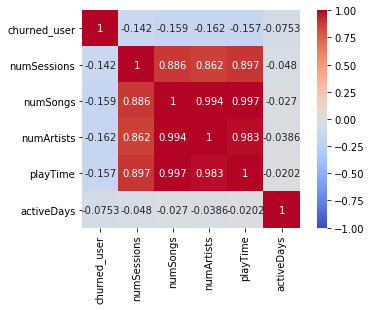

In [21]:
sns.heatmap(temp.corr(),annot=True,fmt='.3g',vmin=-1,vmax=1,center=0,cmap='coolwarm',square=True)

##### Page visits aggregates

In [22]:
w2 = Window.partitionBy('userId','page')
columns = [str(row.page) for row in df.select('page')\
           .dropDuplicates().sort('page').collect()]
df_pageVisits = df.select('userId','page')\
    .withColumn('pageVisits',count('userId').over(w2))\
    .groupby('userId')\
    .pivot('page',columns)\
    .mean('pageVisits')
df_pageVisits = df_pageVisits.na.fill(0)

In [23]:
temp2 = df_pageVisits.join(df_user,df_pageVisits.userId==df_user.userId)\
.select(df_user.churned_user,df_pageVisits['*'],df_user['numSessions'],df_user.activeDays)

In [24]:
temp2_pd = temp2.toPandas()

In [25]:
temp2_pd = temp2_pd.drop(['Cancel','Cancellation Confirmation'],axis=1)

In [26]:
temp2_pd.columns

Index(['churned_user', 'userId', 'About', 'Add Friend', 'Add to Playlist',
       'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong',
       'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade',
       'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade', 'numSessions',
       'activeDays'],
      dtype='object')

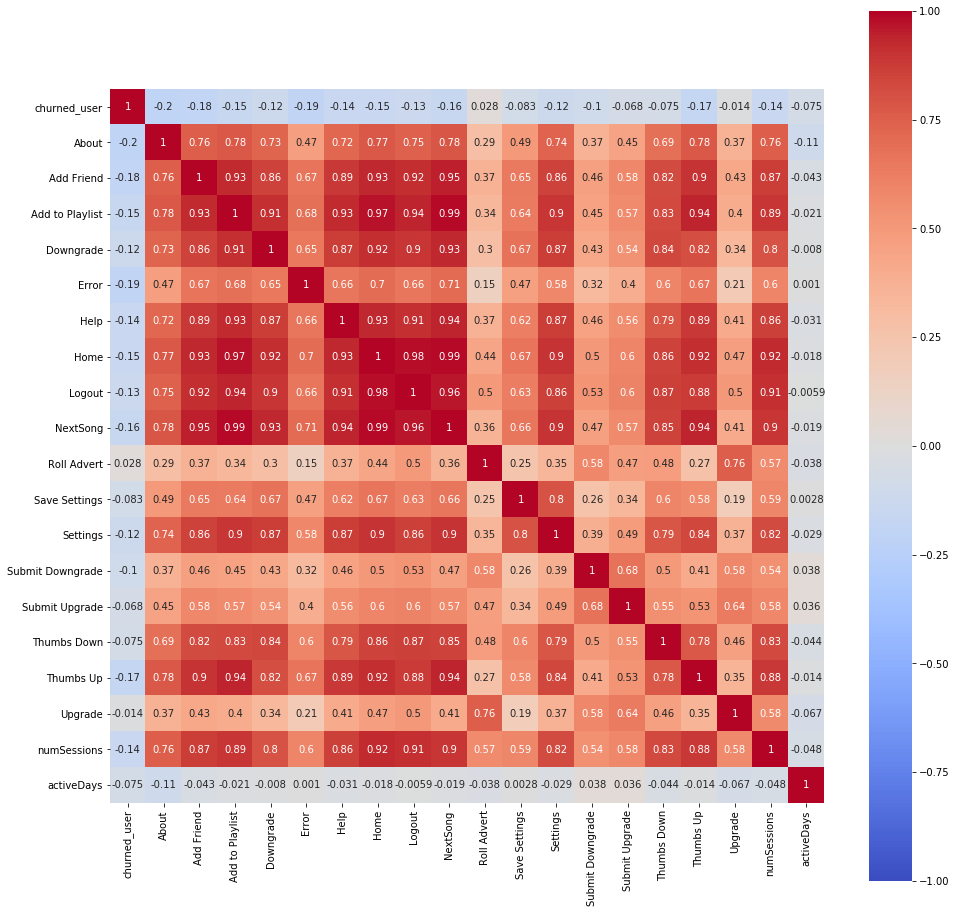

In [27]:
plt.figure(figsize = (16,16))
sns.heatmap(temp2_pd.corr(),annot=True,fmt='.2g'\
            ,vmin=-1,vmax=1,center=0,cmap='coolwarm',square=True)

In [28]:
temp2_pd = temp2_pd.drop(['Add Friend','Add to Playlist', 'Downgrade','Help','Home',\
                          'Logout','NextSong','Settings','Thumbs Down','Thumbs Up'],axis=1)

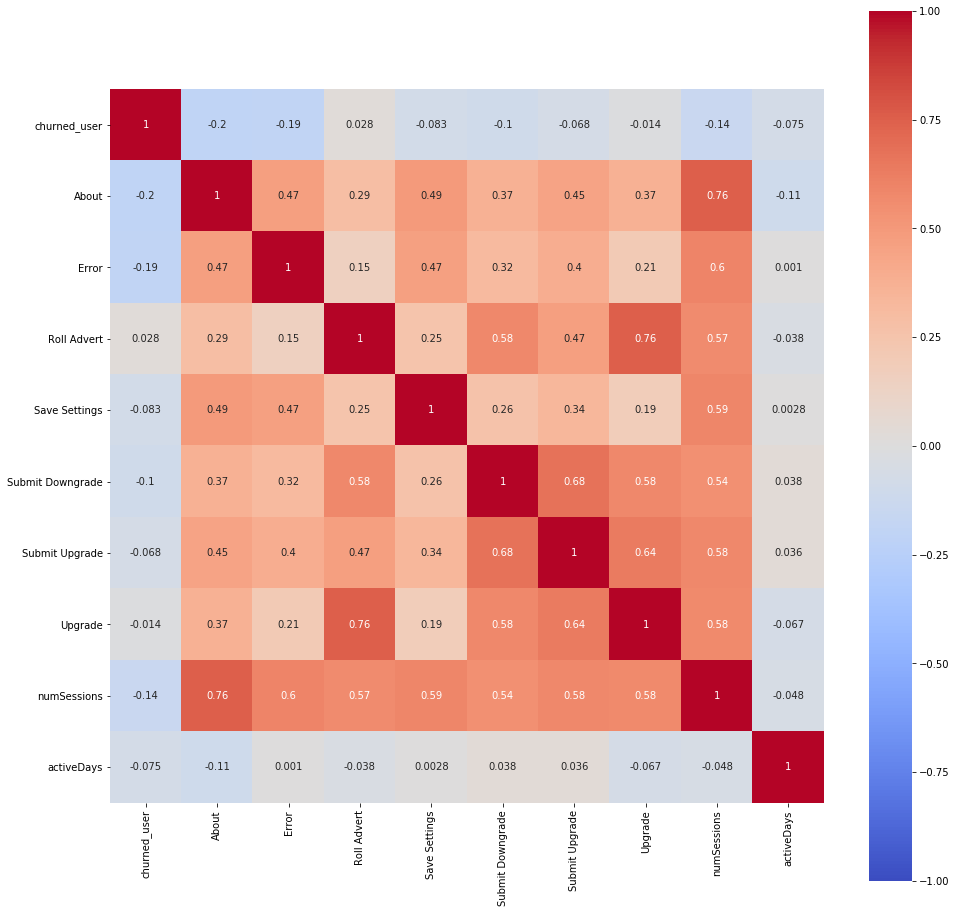

In [29]:
plt.figure(figsize = (16,16))
sns.heatmap(temp2_pd.corr(),annot=True,fmt='.2g'\
            ,vmin=-1,vmax=1,center=0,cmap='coolwarm',square=True)

In [30]:
list(temp2_pd.columns)

['churned_user',
 'userId',
 'About',
 'Error',
 'Roll Advert',
 'Save Settings',
 'Submit Downgrade',
 'Submit Upgrade',
 'Upgrade',
 'numSessions',
 'activeDays']

In [31]:
df_inuse = temp2.select(list(temp2_pd.columns))

### Scale features

In [32]:
# Vector Assembler
cols = df_inuse.drop('userID','churned_user').columns
assembler = VectorAssembler(inputCols=cols,outputCol='feature_vector')
df_inuse = assembler.transform(df_inuse).select('userId','churned_user','feature_vector')

In [33]:
df_inuse.take(1)

[Row(userId='100010', churned_user=0, feature_vector=DenseVector([1.0, 0.0, 52.0, 0.0, 0.0, 0.0, 2.0, 7.0, 11.4259]))]

In [35]:
# Standard Scaler
scaler = StandardScaler(inputCol='feature_vector',
                       outputCol ='features',
                       withStd=True)
scalerModel = scaler.fit(df_inuse)
df_inuse_scaled = scalerModel.transform(df_inuse)

In [36]:
df_inuse_scaled.select('userId','churned_user','features').take(1)

[Row(userId='100010', churned_user=0, features=DenseVector([0.3205, 0.0, 2.413, 0.0, 0.0, 0.0, 0.7817, 0.4779, 0.3488]))]

In [45]:
df_inuse_scaled = df_inuse_scaled.withColumnRenamed("churned_user", "label")

### Modeling 

In [46]:
df_inuse_scaled.take(1)

[Row(userId='100010', label=0, feature_vector=DenseVector([1.0, 0.0, 52.0, 0.0, 0.0, 0.0, 2.0, 7.0, 11.4259]), features=DenseVector([0.3205, 0.0, 2.413, 0.0, 0.0, 0.0, 0.7817, 0.4779, 0.3488]))]

In [47]:
# prepare training and test data, sample by label

ratio = 0.7
train_m = df_inuse_scaled.sampleBy('churned_user',fractions = {0:ratio,1:ratio},
                                  seed = 123)
test_m = df_inuse_scaled.subtract(train_m)

In [48]:
train_m

DataFrame[userId: string, label: bigint, feature_vector: vector, features: vector]

In [49]:
lr = LogisticRegression(maxIter=10)

evaluator_1 = MulticlassClassificationEvaluator(metricName='f1')

paramGrid = ParamGridBuilder()\
            .build()
crossval_lr = CrossValidator(estimator=lr,
                            evaluator = evaluator_1,
                            estimatorParamMaps=paramGrid,
                            numFolds=3)

In [50]:
lr_model = crossval_lr.fit(train_m)

In [51]:
lr_model.avgMetrics

[0.7055942638912569]

In [56]:
lr_model.transform(test_m).take(1)

[Row(userId='300014', label=0, feature_vector=DenseVector([1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 7.0, 59.9772]), features=DenseVector([0.3205, 0.6791, 0.0, 0.5761, 0.0, 1.3626, 0.3908, 0.4779, 1.8309]), rawPrediction=DenseVector([1.1845, -1.1845]), probability=DenseVector([0.7658, 0.2342]), prediction=0.0)]